In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.set_device(0)
from torch import nn
from fastai import *
from fastai.conv_learner import *
from pathlib import Path
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
import matplotlib.image as im

### Load Data

In [3]:
PATH = Path('/mnt/data/extracts/lsun/')
IMG_PATH = PATH/'bedroom'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
sample = False
files = sorted(PATH.glob('bedroom/**/*.jpg'))
if sample:
    CSV_PATH = PATH/'files_sample.csv'
else:
    CSV_PATH = PATH/'files.csv'

with CSV_PATH.open('w') as fo:
    for f in files:
        if (random.random() < 0.1 and sample) or not sample: 
            fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [6]:
sz = 64
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(TMP_PATH, IMG_PATH, CSV_PATH, tfms=tfms, 
                                  skip_header=False, continuous=True)
md = md.resize(128)

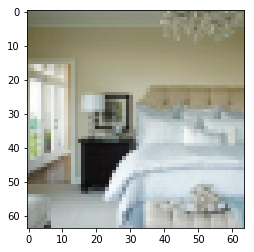

In [7]:
x, y = next(iter(md.trn_dl))
plt.imshow(np.squeeze(md.trn_ds.denorm(x[0])))

### Architecture

#### Discriminator Block

In [8]:
def calc_padding(ni, no, ks, stride):
    return ((no - 1) * stride + ks - ni)//2

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks):
        super(ConvBlock, self).__init__()
        self.c1 = nn.Conv2d(ni, 2*ni, ks, stride=1)
        self.c2 = nn.Conv2d(2*ni, no, ks, stride=2, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(no)
        layer_list = [self.c1, self.c2, self.relu, self.bn]
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [10]:
class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()
        self.cb1 = ConvBlock(3, 20, 3)
        self.cb2 = ConvBlock(20, 40, 3)
        self.cb3 = ConvBlock(40, 80, 3)
        self.pool = nn.AdaptiveAvgPool2d(1)
        layer_list = [self.cb1, self.cb2, self.cb3, self.pool]
        self.layers = nn.Sequential(*layer_list)
    
    def forward(self, x):
        x = self.layers(x)
        return x.mean()

### Generator Block

In [11]:
bs, nz = 64, 100

In [12]:
def create_noise(bs): return V(torch.zeros(bs, nz, 1, 1).normal_(0, 1))

In [13]:
class DeconvBlock(nn.Module):
    def __init__(self, ni, no):
        super(DeconvBlock, self).__init__()
        self.d1 = nn.ConvTranspose2d(ni, no, kernel_size=4, stride=2, padding=1)
        self.th = nn.Tanh()
        
    def forward(self, x):
        x = self.d1(x)
        x = self.th(x)
        return x

In [14]:
class DCGAN_G(nn.Module):
    def __init__(self, nz):
        super(DCGAN_G, self).__init__()
        self.db1 = DeconvBlock(nz, nz // 2)
        self.db2 = DeconvBlock(nz // 2, nz // 4)
        self.db3 = DeconvBlock(nz // 4, nz // 8)
        self.db4 = DeconvBlock(nz // 8, nz // 16)
        self.db5 = DeconvBlock(nz // 16, nz // 32)
        self.db6 = DeconvBlock(nz // 32, nz // 32)
        
    def forward(self, x):
        x = self.db1(x)
        x = self.db2(x)
        x = self.db3(x)
        x = self.db4(x)
        x = self.db5(x)
        x = self.db6(x)
        return x

In [25]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x
    
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)

class DeconvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x
    
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [36]:
#dm = to_gpu(DCGAN_D())
#gm = to_gpu(DCGAN_G(nz))
gm = to_gpu(DCGAN_G(sz, nz, 3, 64, 1))
dm = to_gpu(DCGAN_D(sz, 3, 64, 1))
opt_d = optim.RMSprop(dm.parameters(), lr=1e-4)
opt_g = optim.RMSprop(gm.parameters(), lr=1e-4)

In [38]:
def train(n_epochs, bs):
    g_iter = 0
    gm.train();
    dm.train();
    for epoch in range(n_epochs):
        trn_it = iter(md.trn_dl)
        cb, nb = 0, len(md.trn_dl)
        with tqdm_notebook(total=nb) as pbar:
            while cb < nb:
                set_trainable(dm, True)
                set_trainable(gm, False)
                n_crit = 0 if g_iter < 25 or g_iter % 500 == 0 else 5
                diter = 0
                while diter <= n_crit and cb < nb:
                    dm.zero_grad()
                    for param in dm.parameters(): param.data.clamp_(-0.01, 0.01)
                    actual_img, _  = V(next(trn_it))
                    diter += 1
                    cb += 1
                    priors = create_noise(bs)
                    actual_act = dm(actual_img)
                    gen_img = gm(priors)
                    gen_act = dm(gen_img)
                    diff = actual_act - gen_act
                    diff.backward()
                    opt_d.step()
                    pbar.update()
                set_trainable(gm, True)
                set_trainable(dm, False)
                priors = create_noise(bs)
                gm.zero_grad()
                act = dm(gm(priors)).mean(0).view(1)
                act.backward()
                opt_g.step()
                g_iter += 1

In [46]:
train(1, bs)

In [47]:
gm.eval();

In [48]:
abc = gm(create_noise(bs))

In [45]:
dm

DCGAN_D(
  (initial): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): LeakyReLU(0.2, inplace)
  )
  (extra): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): LeakyReLU(0.2, inplace)
    )
  )
  (pyramid): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): LeakyReLU(0.2, inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): LeakyReLU(0.2, inplace)
    )
    (2): ConvBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

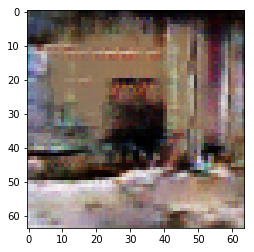

In [49]:
plt.imshow(np.clip(np.squeeze(md.trn_ds.denorm(abc[1])), 0, 1))